<a href="https://colab.research.google.com/github/jingxuanf0214/MIT6.484/blob/main/Copy_of_sim2real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 5

In this assignment, we will tackle the sim2real gap in deep reinforcement learning. Since we don't have access to a real-world system, we will mimic sim-to-real transfer via sim-to-sim transfer (where one simulator is a replacement for the physical world).

There are 290 total points on this problem set.

**_Please fill in your name below:_**

**Name**: Jingxuan Fan

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install git+https://github.com/taochenshh/easyrl.git@sac > /dev/null 2>&1

In [ ]:
%matplotlib inline

import gym
from gym import spaces
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import torch
from tqdm import tqdm
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path
import math
import glob
import io
import base64
from IPython.display import HTML
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from easyrl.agents.ppo_agent import PPOAgent
from easyrl.configs import cfg
from easyrl.configs import set_config
from easyrl.configs.command_line import cfg_from_cmd
from easyrl.engine.ppo_engine import PPOEngine
from easyrl.models.categorical_policy import CategoricalPolicy
from easyrl.models.diag_gaussian_policy import DiagGaussianPolicy
from easyrl.models.mlp import MLP
from easyrl.models.value_net import ValueNet
from easyrl.runner.nstep_runner import EpisodicRunner
from easyrl.utils.common import set_random_seed
from easyrl.utils.gym_util import make_vec_env
from easyrl.utils.common import load_from_json
from gym.envs.classic_control.acrobot import AcrobotEnv
from gym.envs.registration import registry, register
from IPython import display as ipythondisplay

In [ ]:
if 'setup_display' in locals():
    raise RuntimeError("Don't run this cell twice!")

setup_display = True
from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
stolen from https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=8nj5sjsk15IT
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def read_tf_log(log_dir, scalar='train/episode_return/mean'):
    log_dir = Path(log_dir)
    log_files = list(log_dir.glob(f'**/events.*'))
    if len(log_files) < 1:
        return None
    log_file = log_files[0]

    event_acc = EventAccumulator(log_file.as_posix())
    event_acc.Reload()
    tags = event_acc.Tags()

    scalar_return = event_acc.Scalars(scalar)
    returns = [x.value for x in scalar_return]
    steps = [x.step for x in scalar_return]

    return steps, returns

class AcrobotTargetEnv(AcrobotEnv):
    book_or_nips = "nips"


env_name = 'AcrobotTargetEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotTargetEnv',
)

# Experiment Running

We've provided the below code as-is to run your experiments using PPO.  Please do not modify this function.

In [ ]:
# DO NOT MODIFY THIS
def train_ppo(env_name='Acrobot-v1', max_steps=100000):    
    set_config('ppo')
    cfg.alg.num_envs = 1
    cfg.alg.episode_steps = 1024
    cfg.alg.log_interval = 1
    cfg.alg.eval_interval = 20
    
    cfg.alg.max_steps = max_steps
    cfg.alg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cfg.alg.env_name = env_name
    cfg.alg.save_dir = Path.cwd().absolute().joinpath('data').as_posix()
    cfg.alg.save_dir += '/' + env_name

    setattr(cfg.alg, 'diff_cfg', dict(save_dir=cfg.alg.save_dir))

    print(f'====================================')
    print(f'      Device:{cfg.alg.device}')
    print(f'      Total number of steps:{cfg.alg.max_steps}')
    print(f'====================================')

    set_random_seed(cfg.alg.seed)

    env = make_vec_env(cfg.alg.env_name,
                       cfg.alg.num_envs,
                       seed=cfg.alg.seed)
    env.reset()
    ob_size = env.observation_space.shape[0]

    actor_body = MLP(input_size=ob_size,
                     hidden_sizes=[64, 64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)

    critic_body = MLP(input_size=ob_size,
                     hidden_sizes=[64, 64],
                     output_size=64,
                     hidden_act=nn.Tanh,
                     output_act=nn.Tanh)
    
    if isinstance(env.action_space, gym.spaces.Discrete):
        act_size = env.action_space.n
        actor = CategoricalPolicy(actor_body,
                                 in_features=64,
                                 action_dim=act_size)
    elif isinstance(env.action_space, gym.spaces.Box):
        act_size = env.action_space.shape[0]
        actor = DiagGaussianPolicy(actor_body,
                                   in_features=64,
                                   action_dim=act_size,
                                   tanh_on_dist=cfg.alg.tanh_on_dist,
                                   std_cond_in=cfg.alg.std_cond_in)
    else:
        raise TypeError(f'Unknown action space type: {env.action_space}')

    critic = ValueNet(critic_body, in_features=64)
    agent = PPOAgent(actor=actor, critic=critic, env=env)
    runner = EpisodicRunner(agent=agent, env=env)
    engine = PPOEngine(agent=agent,
                       runner=runner)
    engine.train()

    return agent, cfg.alg.save_dir


# Acrobot Introduction

Ben Bitdiddle just started his graduate program studying the *Acrobot*: a double pendulum commonly used as a benchmark in continuous control.  The goal of the benchmark is to find a policy that can swing the tip of the pendulum above the plane defined by the first joint (see the figure below), while only exerting torques on the second joint.  The sooner you hit the termination plane, the higher the reward.

Lab time on the Acrobot is highly contested: Ben can only book 20 minute slots of physical time with the device. Thankfully, OpenAI gym provides a simulation environment for the Acrobot with the exact same physical parameters!

Run the below cell to train a PPO policy in this simulation environment, and report whether Ben Bitdiddle should expect to be able to use the same method to train a policy on the real Acrobot.

![](https://www.researchgate.net/publication/332779048/figure/fig8/AS:753590863937537@1556681471025/Acrobot-environment.ppm)

In [ ]:
agent, save_dir = train_ppo(env_name="Acrobot-v1")

[INFO][2022-03-14 22:26:38]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-03-14 22:26:38]: Creating 1 environments.
[ERROR][2022-03-14 22:26:38]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages


      Device:cpu
      Total number of steps:100000


[INFO][2022-03-14 22:26:45]: Exploration steps: 0
[INFO][2022-03-14 22:26:45]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-03-14 22:26:45]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:27:24]: Exploration steps: 20480
[INFO][2022-03-14 22:27:24]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000020480.pt.
[INFO][2022-03-14 22:27:24]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:27:53]: Exploration steps: 40960
[INFO][2022-03-14 22:27:53]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000040960.pt.
[INFO][2022-03-14 22:27:53]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:28:22]: Exploration steps: 61440
[INFO][2022-03-14 22:28:22]: Saving checkpoint: /content/data/Acrobot-v1/seed_0/model/ckpt_000000061440.pt.
[INFO][2022-03-14 22:28:22]: Saving checkpoint: /cont

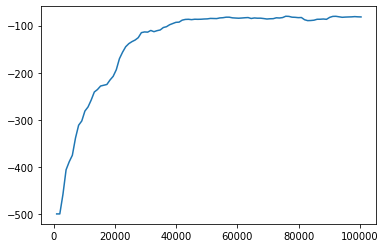

In [ ]:
steps, returns = read_tf_log(save_dir)
plt.plot(steps, returns)

In [ ]:
# Displays a video of the policy.
# Feel free to use this as a template for debugging.

env = wrap_env(gym.make('Acrobot-v1'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):    
        action = agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)    
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
show_video()

Num steps: [69, 89, 93, 69, 73, 90, 73, 85, 72, 62]


In [ ]:
print('The mean number of steps for the pendulum to reach its goal is ' + str(np.mean(num_steps)))
print('The standard deviation for the mean number of steps is ' + str(np.std(num_steps)))

The mean number of steps for the pendulum to reach its goal is 77.5
The standard deviation for the mean number of steps is 10.200490184299968


**Question (10 pts):** Will Ben Bitdittle have enough time to train a policy on the real robot using the same PPO implementation as above? Note that each simulation step is equivalent to 0.2 seconds of time on the real robot.

**Answer:** From the above simulations, we see that using PPO training, the return curve doesn't converge until after ~40000 steps. This corresponds to ~133 min in real time for robots to train well. So Ben would not be able to successfully train his robot using the same PPO implementation as above since it's much more than 20 min. 

# The Sim2Real Gap

Ben is devastated by the above result; how will he train a policy for the Acrobot if it won't converge in his allocated lab time?  

One idea is to simply train a policy in simulation, then evaluate that policy on the real robot (which takes far less time than training from scratch).  Let's try this out, using the environment `AcrobotTargetEnv-v0` as a stand-in for the real world.

In [ ]:
### TODO: evaluate the agent from the simulation environment ("Acrobot-v1") in
### the real world environment ("AcrobotTargetEnv-v0"). Be sure to run at least 10 trials
### Report mean and standard deviation. (10 pts)
env = wrap_env(gym.make('AcrobotTargetEnv-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):    
        action = agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)    
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
show_video()

Num steps: [221, 181, 212, 124, 198, 248, 290, 176, 147, 92]


In [ ]:
print('The mean number of steps for the pendulum to reach its goal is ' + str(np.mean(num_steps)))
print('The standard deviation for the mean number of steps is ' + str(np.std(num_steps)))

The mean number of steps for the pendulum to reach its goal is 188.9
The standard deviation for the mean number of steps is 55.629937983068075


**Question (10 pts):** How does the policy trained in simulation perform when evaluated on the "real" robot?  If there's a difference in performance, postulate why that might be.

**Answer**: we do see a difference in the performance. Specifically, we see that the number of steps it takes for the pendulum to reach the plane is more for this real world environment than the simulated environment where the policy was trained for. This is because that the exact physical parameter of the real world and the robot is unknown. In the simulation, it is hard to model every part of the detailed physical parameters of the real world, but they turn out to be important factors that determine the training time and trajectory. 

# System Identification

One reason for the gap Ben observed is a mismatch between physical parameters in the simulation and in the real world.  If you look at the [code for the Acrobot simulation](https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py), you'll notice a series of parameters on lines 138-149 that define the simulator dynamics.  Perhaps a measurement error was made for one or more of these values, leading to a simulation that does not reflect reality.  One family of solutions for fixing these sorts of issues is *system identification*, which provides us tools for finding the correct values of these parameters from data. 

In this section, you will use a gradient-free numerical optimizer of choice to improve upon the parameters in the Acrobot simulation, with the goal of most closely matching the real world `AcrobotTargetEnv-v0` environment.

Start by generating data of tuples (`env.state`, action, obs) from the real world environment, `AcrobotTargetEnv-v0`, over which to perform your system identification. Later, we'll want the best robot parameters such that when we apply the recorded action when the environment state is the recorded `env.state`, we get as close to the recorded obs as possible.

You can generate as much data as you'd like as long as you don't use more than 20 minutes of robot time (e.g., $\frac{20\text{ minutes}}{0.2\text{ seconds/timestep}} =6000\text{ timesteps}$ ).

In [ ]:
q_shape = 4
u_shape = 1
obs_shape = 6
dataset = {
    "env_state": np.zeros((6000,q_shape)),
    "action": np.zeros((6000,u_shape)),
    "new_obs": np.zeros((6000,obs_shape)),
}

### TODO: generate your data for system ID (10 pts)
env = wrap_env(gym.make('AcrobotTargetEnv-v0'))
observation = env.reset()
for i in range(6000): 
  dataset['env_state'][i,:] = env.state
  action = agent.get_action(observation)[0].tolist() # random sample from actions
  dataset['action'][i,:] = action
  observation, reward, done, info = env.step(action)   
  dataset['new_obs'][i,:] = observation
  if done:
    env.reset()
  
    

Now, try to find parameters that yield new observations that best match your dataset.  There are a number of optimization methods to do this, but for our purposes let's do a simple random search of values in the neighborhood of those that we already have. Specifically, let's randomly and individually scale these parameters from 90% to 110% of their default values and see what combination yields the best performance.

To evaluate your randomly sampled parameters, load the parameters into your `AcrobatSystemIDEnv` and see if for the same environment state and action, how much the next observations differ in terms of L2-norm.

In [ ]:
class AcrobotSystemIDEnv(AcrobotEnv):
    def __init__(self, *args, **kwargs):
        for param in ['dt', 'LINK_LENGTH_1', 'LINK_LENGTH_2', 'LINK_MASS_1', 
                      'LINK_MASS_2', 'LINK_COM_POS_1', 'LINK_COM_POS_2', 
                      'LINK_MOI', 'MAX_VEL_1', 'MAX_VEL_2']:
            if param in kwargs:
                setattr(self, param, kwargs[param])
                del kwargs[param]

        super().__init__(*args, **kwargs)

best_params = {
    'dt' : 0,
    'LINK_LENGTH_1' : 0,
    'LINK_LENGTH_2' : 0,
    'LINK_MASS_1' : 0,
    'LINK_MASS_2' : 0,
    'LINK_COM_POS_1' : 0,
    'LINK_COM_POS_2' : 0,
    'LINK_MOI' : 0,
    'MAX_VEL_1' : 0,
    'MAX_VEL_2' : 0,    
}

### TODO: find parameters of AcrobotSystemIDEnv that match the data in `dataset`,
### and populate them into `best_params` (30 pts)
default_params = {
    'dt' : 0.2,
    'LINK_LENGTH_1' : 1.0,
    'LINK_LENGTH_2' : 1.0,
    'LINK_MASS_1' : 1.0,
    'LINK_MASS_2' : 1.0,
    'LINK_COM_POS_1' : 0.5,
    'LINK_COM_POS_2' : 0.5,
    'LINK_MOI' : 1.0,
    'MAX_VEL_1' : 4 * np.pi,
    'MAX_VEL_2' : 9 * np.pi,    
}



In [ ]:
def optimize_step(params_int, num_trials = 100): 
  loss_L = []
  para_L = []
  for j in range(num_trials):
    env_test =  AcrobotSystemIDEnv(**params_int)
    l2_loss = 0
    for i in range(6000): 
      env_test.state = dataset['env_state'][i,:] 
      action = int(dataset['action'][i,:])
      observation, reward, done, info = env_test.step(action)   
      target_observation = dataset['new_obs'][i,:]
      l2_loss = l2_loss + np.linalg.norm(target_observation-observation)
    loss_L.append(l2_loss)
    params_var={}
    for keys, values in params_int.items():
      scaler = random.uniform(0.9, 1.1)
      params_var[keys] = values*scaler 
    para_L.append(params_var)
  best_ind = loss_L.index(min(loss_L))
  return para_L[best_ind], loss_L[best_ind]


In [ ]:
best_params, loss = optimize_step(default_params, num_trials = 100)

Awesome!  Let's now try to train a policy in a simulation environment with those params loaded, `AcrobotSystemIDSolvedEnv`, and see if we do any better.

In [ ]:
class AcrobotSystemIDSolvedEnv(AcrobotEnv):
    def __init__(self, *args, **kwargs):
        for param in best_params:
            print('Setting', param, 'to', best_params[param])
            setattr(self, param, best_params[param])

        super().__init__(*args, **kwargs)

env_name = 'AcrobotSystemIDSolvedEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotSystemIDSolvedEnv',
)

sysid_agent, sysid_save_dir = train_ppo(env_name='AcrobotSystemIDSolvedEnv-v0')

[INFO][2022-03-14 22:31:43]: Alogrithm type:<class 'easyrl.configs.ppo_config.PPOConfig'>
[INFO][2022-03-14 22:31:43]: Creating 1 environments.
[ERROR][2022-03-14 22:31:44]: Not a valid git repo: /usr/local/lib/python3.7/dist-packages


      Device:cpu
      Total number of steps:100000
Setting dt to 0.21377687406100196
Setting LINK_LENGTH_1 to 1.0515908805880605
Setting LINK_LENGTH_2 to 0.9841143161661691
Setting LINK_MASS_1 to 0.9517833500585927
Setting LINK_MASS_2 to 1.0022549442737219
Setting LINK_COM_POS_1 to 0.49049341374504146
Setting LINK_COM_POS_2 to 0.5283798589034773
Setting LINK_MOI to 0.9606625452157855
Setting MAX_VEL_1 to 12.507552344833906
Setting MAX_VEL_2 to 28.745848206976007


[INFO][2022-03-14 22:31:46]: Exploration steps: 0
[INFO][2022-03-14 22:31:46]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000000000.pt.
[INFO][2022-03-14 22:31:46]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:32:15]: Exploration steps: 20480
[INFO][2022-03-14 22:32:15]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000020480.pt.
[INFO][2022-03-14 22:32:15]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:32:43]: Exploration steps: 40960
[INFO][2022-03-14 22:32:43]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/ckpt_000000040960.pt.
[INFO][2022-03-14 22:32:43]: Saving checkpoint: /content/data/AcrobotSystemIDSolvedEnv-v0/seed_0/model/model_best.pt.
[INFO][2022-03-14 22:33:12]: Exploration steps: 61440
[INFO][2022-03-14 22:33:12]: Saving checkpoint: /content/da

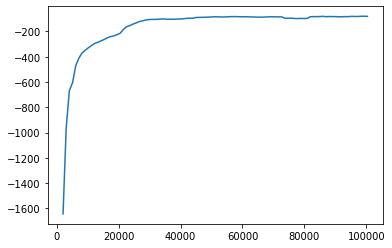

In [ ]:
sysid_steps, sysid_returns = read_tf_log(sysid_save_dir)
plt.plot(sysid_steps, sysid_returns)

In [ ]:
### TODO: evaluate the agent from the sysid simulation environment 
### ("AcrobotSystemIDSolvedEnv-v0") in the real world environment
### ("AcrobotTargetEnv-v0"). Be sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)

env = wrap_env(gym.make('AcrobotTargetEnv-v0'))

num_steps = []
for _ in range(10):
    observation = env.reset()
    step = 0
    for i in range(1024):    
        action = sysid_agent.get_action(observation)[0].tolist()
        observation, reward, done, info = env.step(action)    
        if done:
            step = i
            break
    num_steps.append(step)

env.close()

print('Num steps:', num_steps)
show_video()

Num steps: [172, 240, 117, 125, 183, 150, 201, 165, 147, 223]


In [ ]:
print('The mean number of steps for the pendulum to reach its goal is ' + str(np.mean(num_steps)))
print('The standard deviation for the mean number of steps is ' + str(np.std(num_steps)))

The mean number of steps for the pendulum to reach its goal is 172.3
The standard deviation for the mean number of steps is 38.1812781347089


**Question (10 pts):** How does the sysid agent perform when transferred on the "real" robot in comparison to our baseline agent trained in the "sim" (`Acrobot-v1`)?

**Answer:** I find that the the sysid agent performs better in the real world environment when transferred on the "real" robot in comparison to our baseline agent trained in the "sim". Specifically, the mean number of steps to reach the goal is 172.3 which is less than that of baseline. 

**Question (10 pts):** How does the sysid agent perform when evaluated in its training env, `AcrobotSystemIDSolvedEnv-v0`. You may find plotting the returns during training to be helpful using `read_tf_log`? 

**Answer:** The sysid agent performs better when evaluated in its training env. This is indicated by that the increase of the return curve over training iterations is more steep in the sysid agent case.

**Question (10 pts):** Do you still observe a sim2real gap?  If so, why might that be, and how could it be further minimized? 

**Answer:** I still observe a sim2real gap. This could be that the above gradient free algorithm has not exhaustively explored the parameter space and there exists a better set of parameters that could give better translation to real-world. 

# Domain Randomization

Fortunately, Ben's professor has another solution to improve the quality of transfer between simulation and reality: *domain randomization*.  A good summary of the concept can be found in the [original paper](https://arxiv.org/abs/1710.06537)'s abstract:

> Due to modeling error, strategies that are successful in simulation may not transfer to their real world counterparts. In this paper, we demonstrate a simple method to bridge this "reality gap". By randomizing the dynamics of the simulator during training, we are able to develop policies that are capable of adapting to very different dynamics, including ones that differ significantly from the dynamics on which the policies were trained. This adaptivity enables the policies to generalize to the dynamics of the real world without any training on the physical system.

Let's now implement dynamics randomization for Acrobot. 


In [ ]:
class AcrobotDREnv(AcrobotEnv):
    def reset(self):
        obs = super().reset()

        ### TODO: randomize the dynamics parameters from the defaults slightly
        ### similar to the sysid section (invidually and randomly scale 80% to 120%) (30 pts)
        
        ### ENDTODO
        
        return obs

env_name = 'AcrobotDREnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotDREnv',
)

In [ ]:
dr_agent, dr_save_dir = train_ppo(env_name='AcrobotDREnv-v0')

In [ ]:
dr_steps, dr_returns = read_tf_log(dr_save_dir)
plt.plot(dr_steps, dr_returns)

In [ ]:
### TODO: evaluate the agent from the DR simulation environment 
### ("AcrobotDREnv-v0") in the real world environment
### ("AcrobotTargetEnv-v0").  Make sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)



**Question (10 pts):** How does the DR agent perform when evaluated in its training env, `AcrobotDREnv-v0`. You may find plotting the returns during training to be helpful using `read_tf_log`?

**Answer:** 

**Question (10 pts):**:  How does the DR agent perform in comparison to the sysid agent when transferred to our real world environment? Why is this so?

**Answer**: 


## Robustness vs Performance Tradeoff

Next, try making your domain randomization less varied by narrowing the distributions of parameters you sample from. Perhaps we introduced too much randomization last round to train a more robust policy in exchange for some potential performance. Instead of scaling the parameters by 80% to 110%, only scale them from 95% to 105%.

In [ ]:
class AcrobotDRCompareEnv(AcrobotEnv):
    def reset(self):
        obs = super().reset()

        ### TODO: randomize the dynamics parameters (10 pts)

        ### ENDTODO

        return obs

env_name = 'AcrobotDRCompareEnv-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:AcrobotDRCompareEnv',
)

dr_compare_agent, dr_compare_save_dir = train_ppo(env_name='AcrobotDRCompareEnv-v0')
dr_compare_steps, dr_compare_returns = read_tf_log(dr_compare_save_dir)
plt.plot(dr_compare_steps, dr_compare_returns)

In [ ]:
### TODO: evaluate the dr_compare_agent in the real world environment
### ("AcrobotTargetEnv-v0").  Make sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)



**Question (10 pts):** Does narrowing the range of domain randomization help with transfer to reality? Why?

**Answer**: 

# Knowledge Distillation 

Unfortunately, the velocity sensors on the lab's Acrobat broke and are no longer usable. Thus, all of Ben's agents trained thus far that account for velocity in the state space can no longer function.

Fortunately, Ben's professor has yet another idea to allow for transfer between simulation and reality: *knowledge distillation*. A summary of this idea can be found [here](https://intellabs.github.io/distiller/knowledge_distillation.html):

> Knowledge distillation is model compression method in which a small model is trained to mimic a pre-trained, larger model (or ensemble of models). This training setting is sometimes referred to as "teacher-student", where the large model is the teacher and the small model is the student (we'll be using these terms interchangeably).

This scenario is common when in simulation, we can have privileged information that may not be possible in reality (more sensors, perfect state estimation, etc.).

In our case, we could train a teacher network in simulation with full access to a simulated robot with working velocity sensors. We would then train our student network with a more limited state space to predict actions that match that of the teacher. Let's try to implement this.

In [ ]:
# defining our environments
class NoVelocityAcrobotEnv(AcrobotEnv):
    book_or_nips = "book"    
    
    def __init__(self):
        AcrobotEnv.__init__(self)
        high = np.array(
            [1.0, 1.0, 1.0, 1.0], dtype=np.float32
        )
        low = -high
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        
    def _get_ob(self):
        s = self.state
        assert s is not None, "Call reset before using AcrobotEnv object."

        obs = np.array(
            [
                np.cos(s[0]), np.sin(s[0]), np.cos(s[1]), np.sin(s[1]), # no velocity
            ], dtype=np.float32
        )
                    
        return obs

class NoVelocityAcrobotTargetEnv(NoVelocityAcrobotEnv):
    book_or_nips = "nips"    
    
        
env_name = 'NoVelocityAcrobot-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:NoVelocityAcrobotEnv',
)

env_name = 'NoVelocityAcrobotTarget-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:NoVelocityAcrobotTargetEnv',
)

In [ ]:
# get our vanilla agent trained on the full simulated basic env
# if you have this cached from Q1 no need to re-train, just run `teacher_agent = agent`
# in practice, we could use one of our better agents (e.g., the agent trained on domain randomization
# or sysid) but let's use the basic agent for simplicity

teacher_agent, teacher_save_dir = train_ppo(env_name="Acrobot-v1")
teacher_steps, teacher_returns = read_tf_log(teacher_save_dir)
plt.plot(teacher_steps, teacher_returns)

# teacher_agent = agent

Now that we have our teacher, let's generate a dataset of observations and policy outputs that we'll try to get our student to later match. Note that solely training on executed *actions* is insufficient, so we'll need to store the parameters of our `Categorical` distribution (the logits representing each of the 3 discrete actions) for every given observation.

In [ ]:
num_transitions = 20000

stud_dataset = {
    'obs': np.zeros((num_transitions, 6)),
    'dist_params': np.zeros((num_transitions, 3)),   
}

class StudentObsActionDataset(torch.utils.data.Dataset):
    def __init__(self, stud_dataset):
        self.states = stud_dataset['obs']
        self.params = stud_dataset['dist_params']
        
    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        sample = dict()
        sample['state'] = self.states[idx][:4] # no velocity information
        sample['dist_params'] = self.params[idx]
        return sample


### TODO: Collect offline dataset of teacher observations and policy outputs
###       from our simulated environment, `Acrobot-v1` which has access to the velocity (30 pts)
'''
note: to get an action out of our `PPOAgent` object, you can pass an observation as a 
tensor to the teacher_agent's actor to get a `Categorical` distribution
'''


Awesome, now that we have our offline dataset, we just need our student policy (which will take in observations without velocities) to output the same distribution over discrete actions! Note that our `StudentObsActionDataset` wrapper is removing velocities for you already.

In [ ]:
# model 
student_body = MLP(
    input_size=4, # no more angular velocity
    hidden_sizes=[64, 64],
    output_size=64,
    hidden_act=nn.Tanh,
    output_act=nn.Tanh
)
act_size = env.action_space.n
student = CategoricalPolicy(
    student_body,
    in_features=64,
    action_dim=act_size
).to(cfg.alg.device)

# setup
optimizer = torch.optim.Adam(student.parameters(), lr=0.0005)
max_epochs = 50
dataloader = torch.utils.data.DataLoader(dset, batch_size=256, shuffle=True)
criterion = torch.nn.MSELoss()

# train loop
pbar = tqdm(range(max_epochs), desc='Epoch')
losses = []
for iter in pbar:
    avg_loss = []
    for batch_idx, sample in enumerate(dataloader):
        states = sample['state'].float().to(cfg.alg.device)
        expert_logits = sample['dist_params'].float().to(cfg.alg.device)

        ### TODO: optimize the student outputs with respect to the data (10 pts)

        ####
        
        pbar.set_postfix({'loss': loss.item()})
        losses.append(loss.item())

plt.plot(losses)


Let's evaluate the performance of our trained student in a simulated environment with no velocity in the state before we try evaluating it on our real robot with broken velocity sensors.

In [ ]:
student.eval()

### TODO: Evaluate the student on `NoVelocityAcrobot-v0`. Be sure to run at least 10 trials
### Report mean and standard deviation. (10 pts)


In [ ]:
student.eval()

### TODO: Evaluate the student on `NoVelocityAcrobotTarget-v0`. Be sure to run at least 10 trials.
### Report mean and standard deviation. (10 pts)


**Question (10 pts):**:  How does the student agent perform in the simulated environment without velocity (`NoVelocityAcrobot-v0`) in comparison to the teacher on the same environment with velocity measurements (`Acrobot-v1`)? 

**Answer**: 

**Question (10 pts):**:  How does the student agent perform in the target environment without velocity (`NoVelocityAcrobotTarget-v0`) in comparison to the other agents we've trained so far? Why is this so?

**Answer**: 

# Results Comparison

Make a single plot comparing the results of transferring an agent using our three methods to reality: the naive simulation (`Acrobot-v1`), system identification (`AcrobotSystemIDSolvedEnv`), and domain randomization (`AcrobotDREnv-v0` and `AcrobotDRCompareEnv-v0`). We won't include our knowledge distillation method as the student uses a different state space which makes it a different comparison.

As always, be sure to communicate both the mean and variance of your results. Be creative in how you present these results; what is the best way of illustrating the relative strengths and weaknesses of these methods, and making the plot clearly communicate the experiments that were run?

(30 pts)

In [ ]:
### todo: make pretty plots.


# Survey (bonus points, 10 pts)
Please fill out [this anonymous survey](https://docs.google.com/forms/d/e/1FAIpQLSeG6LstBLYq61NeFfhXja6Lu9-roPpEiIFP8gkJ-5fNygwrKw/viewform?usp=sf_link) and enter the code below to receive credit. Thanks!

**Bonus code:** 

# Submission
Generate an HTML for submission by running the cell below, ensuring that your plots/code/figures show up nicely and modifying the notebook path as needed to match your Google Drive set up. Alternatively you can run the `jupyer nbconvert` commands on your local machine after downloading this notebook as an `ipynb`.

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')
!jupyter nbconvert --to html '/content/drive/My Drive/path_to_notebook.ipynb'